Eval

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /path/to/your/log/director

Manual Eval of Performance on Test Set, Imbalanced Classifications and Confusion Matrix

In [9]:
path_last_checkpoint = r'path_to_your_last_checkpoint_of_training'
model = 'gpt2'
test_data_path = r'path_to_your_test_data'
max_length = 1024

In [2]:
import os
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset


from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import json

import re

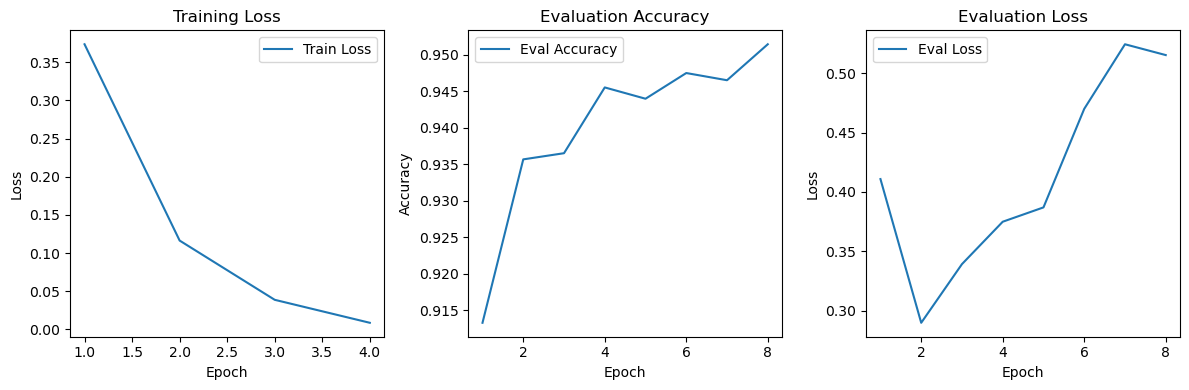

In [6]:
# Load the trainer_state.json file
with open(path_last_checkpoint + r'\trainer_state.json') as f:
    data = json.load(f)

train_losses = [log['loss'] for log in data['log_history'] if 'loss' in log]
train_epochs = range(1, len(train_losses) + m1)

eval_accuracies = [log['eval_accuracy'] for log in data['log_history'] if 'eval_accuracy' in log]
eval_acc_epochs = range(1, len(eval_accuracies) + 1)

eval_losses = [log['eval_loss'] for log in data['log_history'] if 'eval_loss' in log]
eval_loss_epochs = range(1, len(eval_losses) + 1)

# Plotting
plt.figure(figsize=(12, 4))

# Training loss
plt.subplot(1, 3, 1)
plt.plot(train_epochs, train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Evaluation accuracy
plt.subplot(1, 3, 2)
plt.plot(eval_acc_epochs, eval_accuracies, label='Eval Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Evaluation Accuracy')
plt.legend()

# Evaluation loss
plt.subplot(1, 3, 3)
plt.plot(eval_loss_epochs, eval_losses, label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evaluation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
checkpoint_load_path = r"path_to_your_best_checkpoint"

tokenizer = AutoTokenizer.from_pretrained(model)

if model is 'gpt2:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForSequenceClassification.from_pretrained(checkpoint_path)

In [10]:
test_data = pd.read_json(test_data_path, lines=True)

def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

test_data['text'] = test_data['text'].apply(clean_text)
test_text = test_data['text'].to_list()
test_label = test_data['label'].to_list()

In [ ]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(text, padding = 'max_length', truncation=True, max_length=self.max_length, return_tensors='pt')
        item = {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label)
        }
        return item

    def __len__(self):
        return len(self.labels)

In [5]:
test_dataset = TextClassificationDataset(test_text, test_label, tokenizer, max_length)

In [6]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'precision': precision_score(labels, predictions, average='weighted'),
        'recall': recall_score(labels, predictions, average='weighted'),
        'f1': f1_score(labels, predictions, average='weighted'),
    }

In [11]:
trainer = Trainer(
    model=model,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

test_predictions = trainer.predict(test_dataset)

test_metrics = test_predictions.metrics

print(test_metrics)

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/1821 [00:00<?, ?it/s]

{'test_loss': 5.606103420257568, 'test_accuracy': 0.5598654400659069, 'test_precision': 0.667509334350885, 'test_recall': 0.5598654400659069, 'test_f1': 0.543640043466758, 'test_runtime': 462.3153, 'test_samples_per_second': 31.507, 'test_steps_per_second': 3.939}


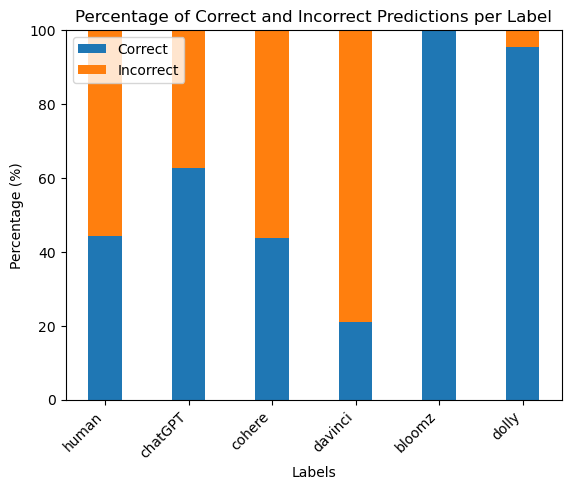

In [35]:
predictions = np.argmax(test_predictions.predictions, axis=1)
true_labels = test_predictions.label_ids

cm = confusion_matrix(true_labels, predictions)

correct_percentages = np.diag(cm) / np.sum(cm, axis=1)
incorrect_percentages = 1 - correct_percentages

fig1, ax1 = plt.subplots()
bar_width = 0.4

label_mapping = {
    'human': 0,
    'chatGPT': 1,
    'cohere': 2,
    'davinci': 3,
    'bloomz': 4,
    'dolly': 5
}

labels = list(label_mapping.keys())
index = np.arange(len(labels))

ax1.bar(index, correct_percentages * 100, bar_width, label='Correct')
ax1.bar(index, incorrect_percentages * 100, bar_width, bottom=correct_percentages * 100, label='Incorrect')

ax1.set_xlabel('Labels')
ax1.set_ylabel('Percentage (%)')
ax1.set_title('Percentage of Correct and Incorrect Predictions per Label')
ax1.set_xticks(index)
ax1.set_xticklabels(labels, rotation=45, ha='right')
ax1.legend()

plt.show()

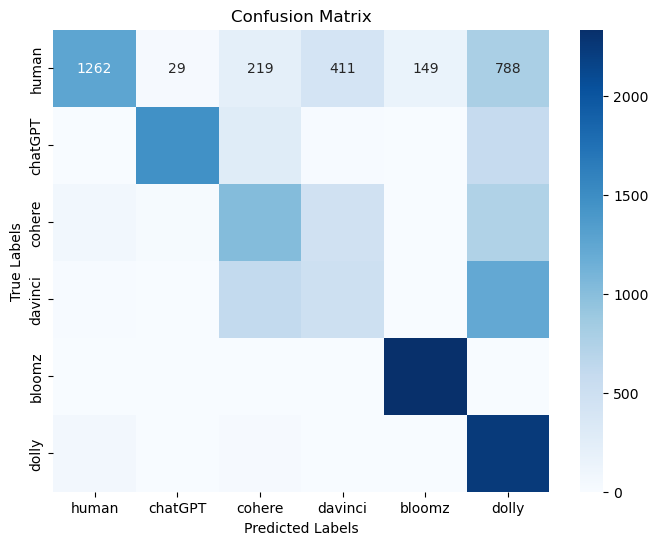

In [36]:
fig2, ax2 = plt.subplots(figsize=(8, 6))

# Use the keys of the label_mapping dictionary as the labels
labels = list(label_mapping.keys())

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2, xticklabels=labels, yticklabels=labels)

ax2.set_xlabel('Predicted Labels')
ax2.set_ylabel('True Labels')
ax2.set_title('Confusion Matrix')

plt.show()